Steps
1. Extraction from sql
2. Transformation
3. Train-Test split
4. Model selection <br>
4.1. Outlier detection <br>
4.2 Hypothesis <br>
4.3 Statistical test <br>
4.4 Plot ACF and PACF <br>
4.5  Parameters optimisation
5. Models Training
9. Testing
10. Evaluation


In [73]:
#Importing dependincies
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose, STL
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
import pyodbc
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.gofplots import qqplot 
from typing import Union, List
from tqdm import tqdm_notebook
from itertools import product
from matplotlib.ticker import MultipleLocator
from sklearn.metrics import mean_absolute_percentage_error






%matplotlib inline

## 1. Extraction from  SQL server

In [14]:

# Connection parameters
server = 'LOUVERTURE\MSSQLSERVER01'
#input('Your server name')
database = 'AdventureWorks2019'


In [15]:

#  connection using Windows Authentication
conn = pyodbc.connect('DRIVER={SQL Server};SERVER='+server+';DATABASE='+database+';Trusted_Connection=yes;')

# Creating a cursor
cursor = conn.cursor()

# query
cursor.execute("SELECT * FROM Total_Sales")

# Fetch data
rows = cursor.fetchall()

#  data to  DataFrame
data = pd.DataFrame([tuple(row) for row in rows], columns=[column[0] for column in cursor.description])





In [16]:
data= pd.DataFrame(data)
data

,ProductID,OrderDate,Quantity,Category,TerritoryID,name
0,768,2011-05-31,4,A,6,Bikes
1,778,2011-05-31,2,A,6,Bikes
2,707,2011-05-31,3,B,6,Accessories
3,711,2011-05-31,4,B,6,Accessories
4,762,2011-07-01,23,A,6,Bikes
...,...,...,...,...,...,...
8728,880,2014-06-27,1,C,6,Accessories
8729,934,2014-06-27,1,C,6,Accessories
8730,877,2014-06-29,1,C,6,Accessories
8731,929,2014-06-29,1,C,6,Accessories


## 2. transform the data for analysis

In [17]:
#Lets create a  fucntion that processes the dataframe for timeseries analysis
df = pd.DataFrame(data)
data

def process_dataframe(df, date_column, period_type, all_periods):
   
    df['period'] = pd.to_datetime(df[date_column]).dt.to_period(period_type)
    df.sort_values(by='period', inplace=True)
    df_full = pd.DataFrame(all_periods, columns=['period']).merge(df, on='period', how='left')
    df_full['period'] = pd.Categorical(df_full['period'], categories=all_periods, ordered=True)
    df_full['period_index'] = df_full['period'].cat.codes + 1
    df_summary = df_full[['period_index', 'Quantity']].groupby('period_index').sum().reset_index(drop=True)


    return df_summary





In [18]:
# we need to define the period type and the period of our project
min_date = data['OrderDate'].min()
max_date = data['OrderDate'].max()
period_type = 'W' 
all_periods = pd.period_range(start=min_date, end=max_date, freq=period_type)

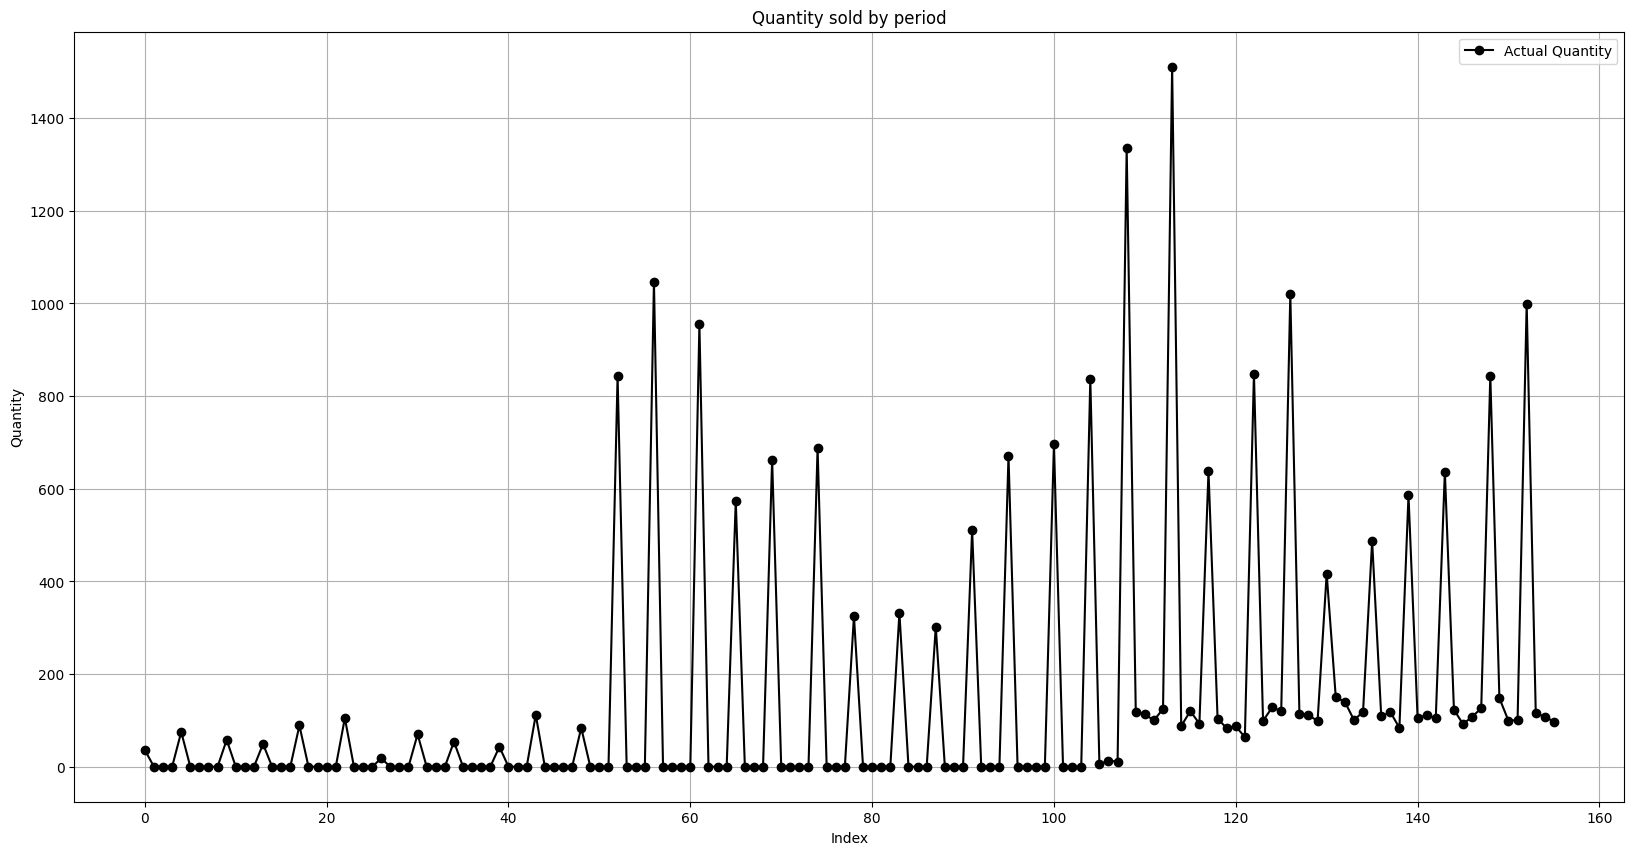

In [80]:
df= process_dataframe(data.loc[data['Category']=='C' ],'OrderDate',period_type,all_periods)[:156] ## we will work with 156 week , ( 3 years)




plt.figure(figsize=(20, 10))
plt.plot(df['Quantity'], label='Actual Quantity', color='black', marker='o', linestyle='-')  


plt.title('Quantity sold by period')
plt.xlabel('Index')
plt.ylabel('Quantity')
plt.legend()
plt.grid(True)
plt.show()


## 3. Test-train split

In [45]:
train= df[:-12]
test =df[-12:]
print(len(train))
print(len(test))

144
12


## 3. Outlier detection

By plotting the distribution , we can vizually analyse  the frequency of quantity 

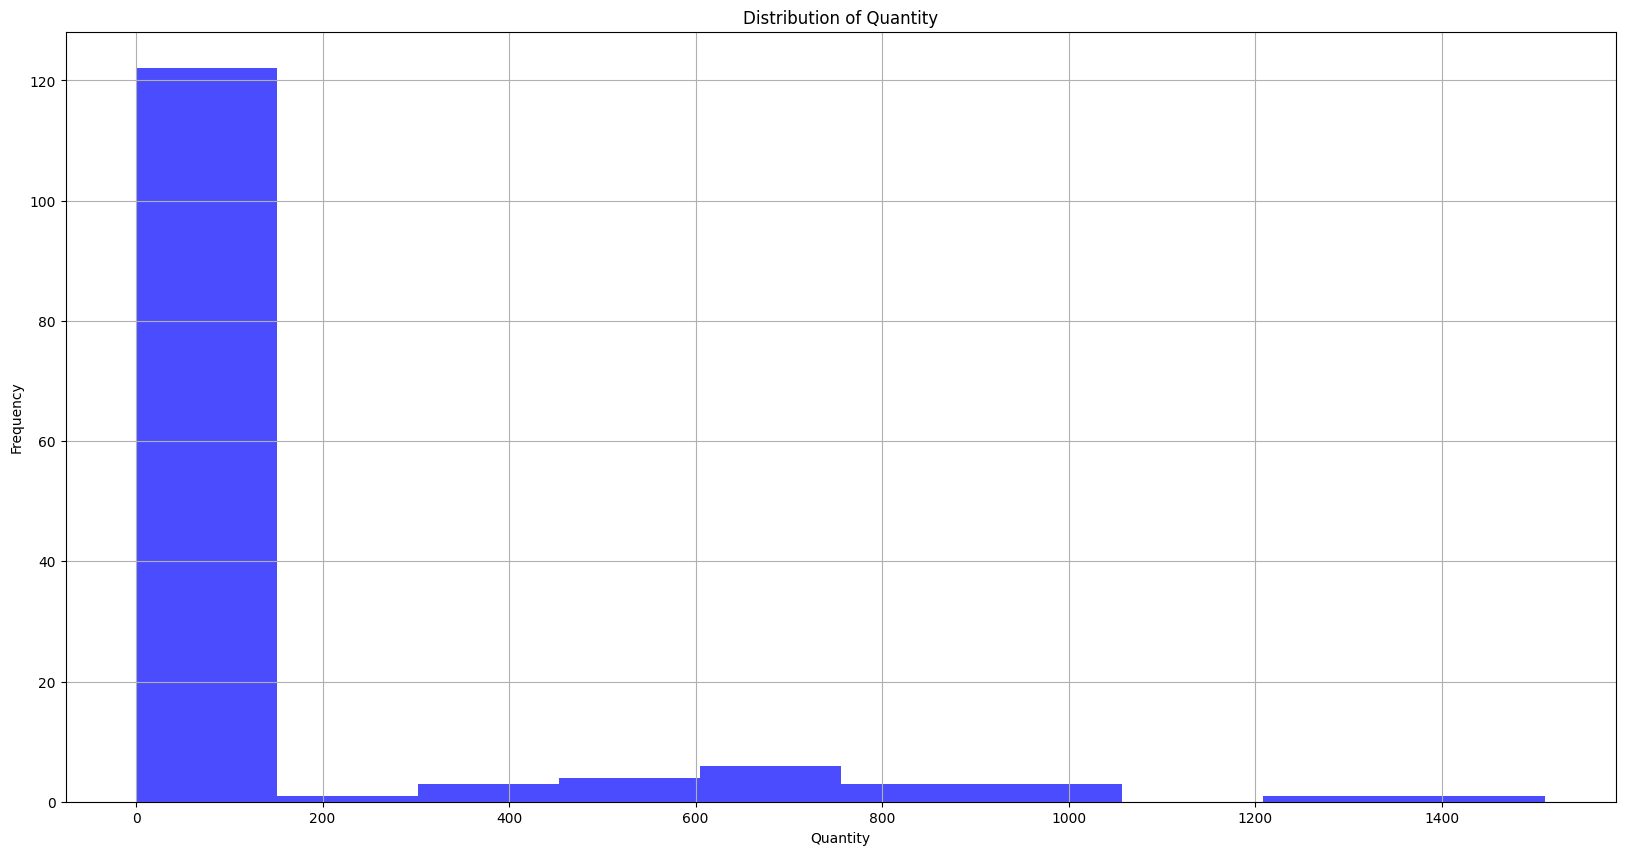

In [46]:
plt.figure(figsize=(20, 10))
plt.hist(train['Quantity'], bins=10, color='Blue', alpha=0.7)
plt.title('Distribution of Quantity')
plt.xlabel('Quantity')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


I decided to save a copy of the train set to compare later . We will evaluate if removing the outliers has a beneficial impact on the predictions

In [47]:
train1=train.copy()

In [48]:

mean = train1['Quantity'].mean()
std_dev = train1['Quantity'].std()

# Compute the Z-score for each data point
train1['z_score'] = (train1['Quantity'] - mean) / std_dev

# Define a threshold for identifying outliers
threshold = 3

# Identify outliers
outliers = train1[(train1['z_score'] > threshold) | (train1['z_score'] < -threshold)]


In [49]:
outliers

,Quantity,z_score
56,1047.0,3.244711
108,1336.0,4.274601
113,1511.0,4.898236
126,1020.0,3.148493


here is our new distribution

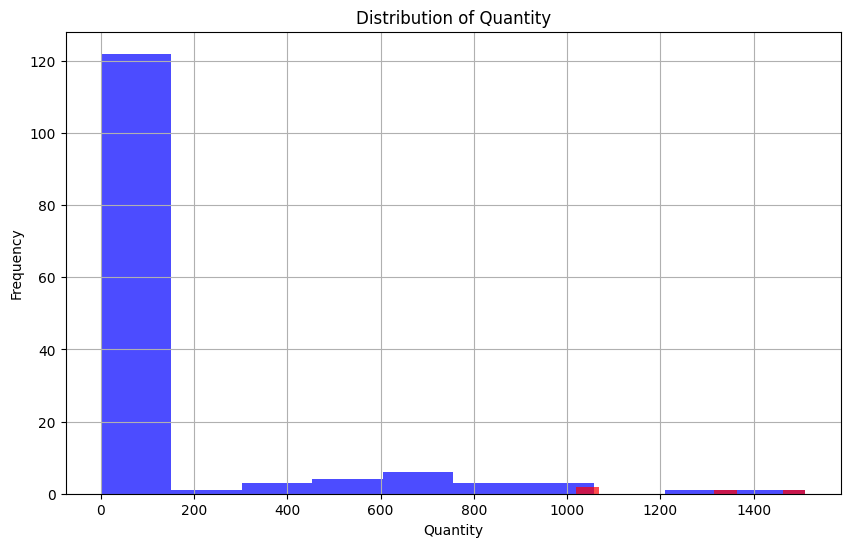

In [50]:
plt.figure(figsize=(10, 6))
plt.hist(train['Quantity'], bins=10, color='blue', alpha=0.7)
plt.hist(outliers['Quantity'], bins=10, color='red', alpha=0.7)

plt.title('Distribution of Quantity')
plt.xlabel('Quantity')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [51]:

# Replace outliers with the mean
train1.loc[train1['z_score'] > threshold, 'Quantity'] = mean
train1.loc[train1['z_score'] < -threshold, 'Quantity'] = mean
train1 =train1.drop('z_score',axis=1)

## 4 . Model selection

### 4.1 decompose the dataframe

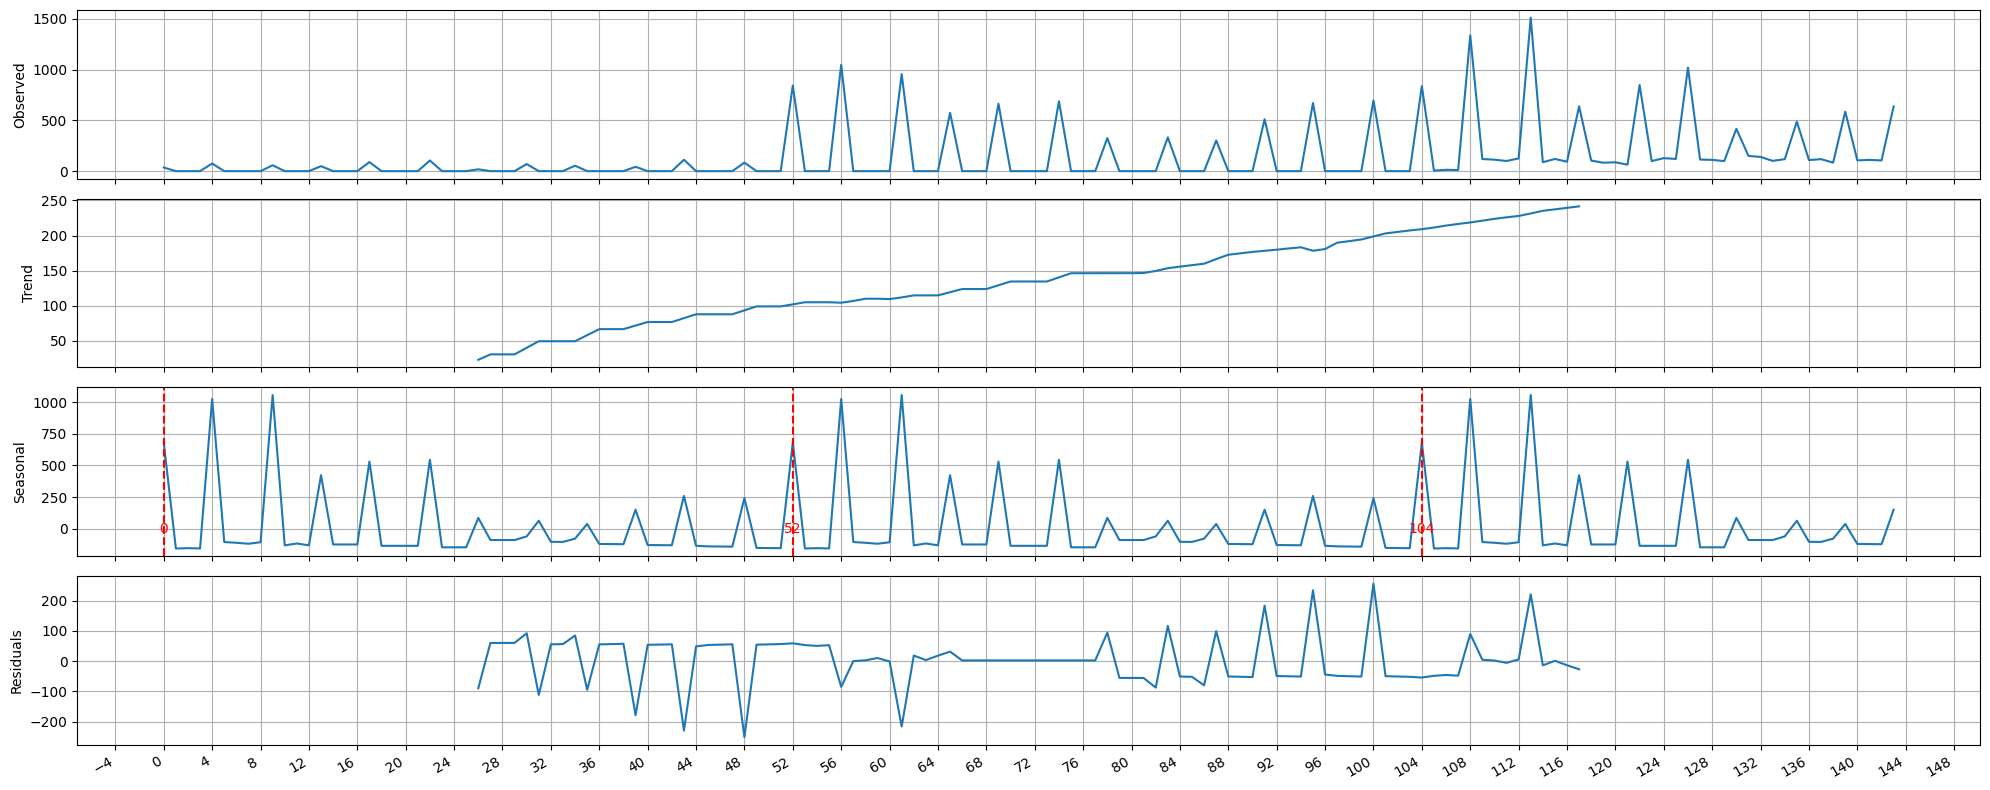

In [52]:

df_decomposed = seasonal_decompose(x=train['Quantity'], model='additive', period=52)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(20, 8))

ax1.plot(df_decomposed.observed)
ax1.set_ylabel('Observed')
ax1.grid(True)  

ax2.plot(df_decomposed.trend)
ax2.set_ylabel('Trend')
ax2.grid(True)  

ax3.plot(df_decomposed.seasonal)
ax3.set_ylabel('Seasonal')
ax3.grid(True)  

ax4.plot(df_decomposed.resid)
ax4.set_ylabel('Residuals')
ax4.grid(True)  

ax4.xaxis.set_major_locator(MultipleLocator(4))

for i, label in enumerate(['0', '52', '104']):
    ax3.axvline(x=i*52, color='r', linestyle='--')  
    ax3.text(i*52, 0, label, color='r', ha='center', va='center') 

fig.autofmt_xdate()  
plt.tight_layout()
plt.show() 

### 4.2 The addfuller test

Testing for stationarity

In [28]:

#  the Augmented Dickey-Fuller test 
Adf_result = adfuller(train['Quantity'])  

# Print the results
print(f'ADF Statistic is: {Adf_result[0]}')
print(f'p-value: {Adf_result[1]}')



ADF Statistic is: -1.32225126306499
p-value: 0.6189318562950266


The adf is a negative number but With a PValue of 0.91 we can not assume stationarity . we will apply differencing

ADF Statistic  is: -5.495832282397949
p-value: 2.124555312277191e-06


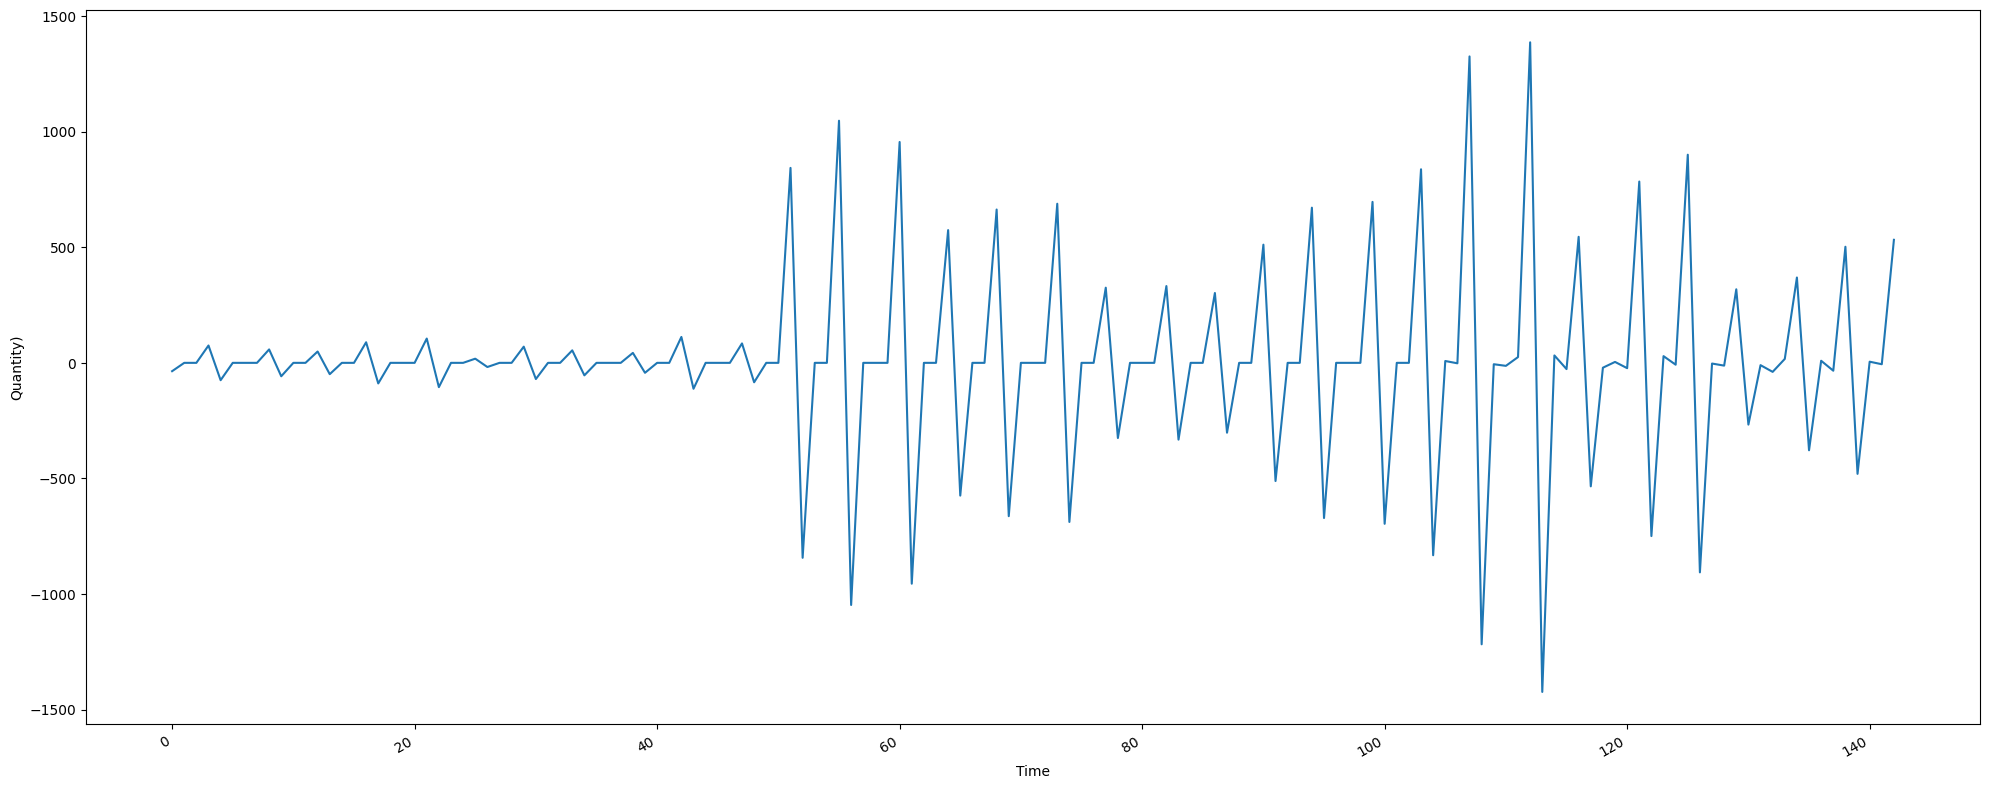

In [53]:
#applying diff to make the data stationarry
Quantity_diff = np.diff(train['Quantity'], n=1)
fig, ax = plt.subplots(figsize= (20,8))

ax.plot(Quantity_diff)
ax.set_xlabel('Time')
ax.set_ylabel('Quantity)')



fig.autofmt_xdate()
plt.tight_layout()

plt.show
Adf_result = adfuller(Quantity_diff)

print(f'ADF Statistic  is: {Adf_result[0]}')
print(f'p-value: {Adf_result[1]}')


Adf statisitic is a negative number and P value is small negative number. we can assume staionnarity

By plotting ACF an PACF we will find out if our model will be and autoregretion or moving average

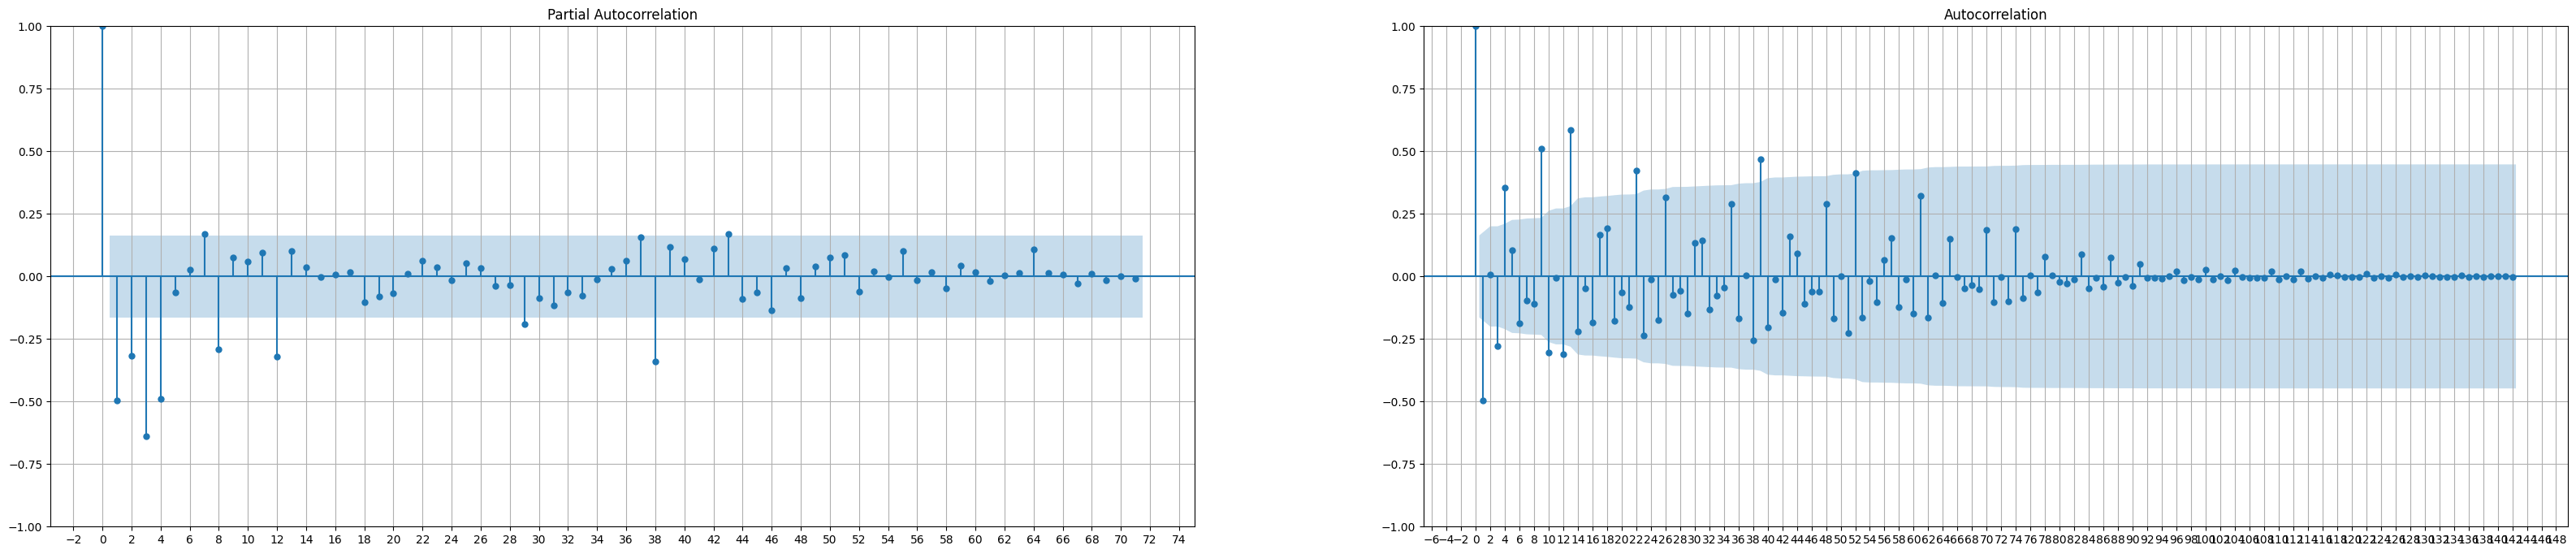

In [54]:

# Create subplots
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharex=False, figsize=(40, 8))

# Partial Autocorrelation plot
plot_pacf(Quantity_diff, ax=ax1, lags=int(len(Quantity_diff) * 0.5))
ax1.xaxis.set_major_locator(MultipleLocator(2))
ax1.grid(True)  # Adding a grid

# Autocorrelation plot
plot_acf(Quantity_diff, ax=ax2, lags=len(Quantity_diff) - 1)
ax2.xaxis.set_major_locator(MultipleLocator(2))
ax2.grid(True)  # Adding a grid

# Display the plot
plt.show()


Base on the acf and pacf, we see that correalation exist at  different lags that can imply hidden seanonal patterns or noize
this is coherent with what we have seen in the decomposition. 

### 4.3 model selection based on AIC optimization

We will now proceed with a sarima model 
to do so we will chose the best AIC by gridsearching p,,q, P,Q and the trrend . season is still 52

In [55]:
def optimize_SARIMA(endog: Union[pd.Series, list], order_list: List[tuple], d: int, D: int, s: int, trend_list: List[str]) -> pd.DataFrame:
    results = []

    # this function takes in the serie we are tainning on, a range of values of p,q,P and Q, the values of d, D , S and a list of trend that we want to try and return a dataframe with the best parameters
    
    for order in tqdm_notebook(order_list):
        for trend in trend_list:
            try:
                model = SARIMAX(
                    endog,
                    order=(order[0], d, order[1]),
                    seasonal_order=(order[2], D, order[3], s),
                    simple_differencing=False,
                    trend=trend
                ).fit(disp=False)
            except Exception as e:
                print(f"Failed to fit SARIMAX for order {order} and trend {trend}: {e}")
                continue

            aic = model.aic
            results.append([order, trend, aic])

    result_df = pd.DataFrame(results, columns=['(p,q,P,Q)', 'Trend', 'AIC'])

    # Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [56]:


ps = range(0, 5)
qs = range(0, 5)
Ps = range(0, 2)  
Qs = range(0, 2)  
# Creating the order list with the product of these ranges
SARIMA_order_list = list(product(ps, qs, Ps, Qs))

#  the seasonal length for weekly data
s = 52

# Setting up the d and D parameters
d = 1
D = 1

#  trend options to try
trend_list = [ 'ct', 't']

#  the optimization function
SARIMA_result_df = optimize_SARIMA(train['Quantity'], SARIMA_order_list, d, D, s, trend_list)

SARIMA_result_df

  0%|          | 0/100 [00:00<?, ?it/s]

,"(p,q,P,Q)",Trend,AIC
0,"(3, 3, 0, 0)",ct,1226.748396
1,"(4, 3, 0, 0)",ct,1228.056834
2,"(3, 3, 1, 0)",ct,1228.751552
3,"(3, 3, 0, 1)",ct,1228.844442
4,"(3, 4, 0, 0)",ct,1229.551194
...,...,...,...
195,"(0, 0, 0, 0)",ct,1339.636001
196,"(0, 0, 1, 0)",ct,1341.355908
197,"(0, 0, 0, 1)",ct,1341.362138
198,"(0, 0, 1, 1)",t,1341.433428


## models Tainning

we will train both the full train and the one without outliers

In [64]:
train1

,Quantity
0,36.0
1,0.0
2,0.0
3,0.0
4,75.0
...,...
139,586.0
140,106.0
141,111.0
142,105.0


In [65]:
trainingsets= [train, train1]

                                      SARIMAX Results                                      
Dep. Variable:                            Quantity   No. Observations:                  144
Model:             SARIMAX(3, 1, 3)x(0, 1, [], 52)   Log Likelihood                -623.873
Date:                             Mon, 06 May 2024   AIC                           1265.745
Time:                                     23:19:17   BIC                           1288.343
Sample:                                          0   HQIC                          1274.862
                                             - 144                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    -16.6483     36.059     -0.462      0.644     -87.323      54.026
drift          0.1577      

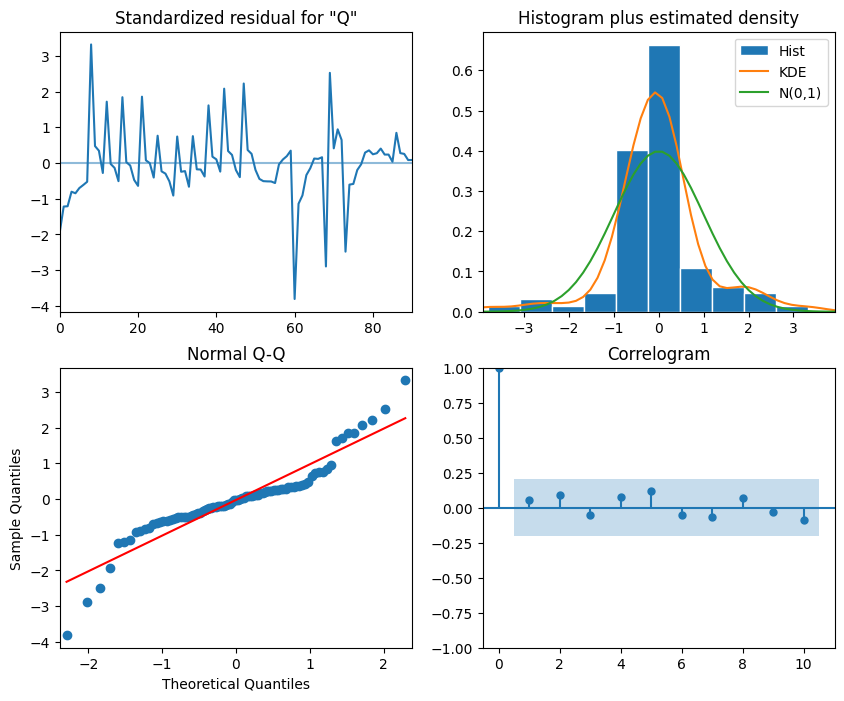

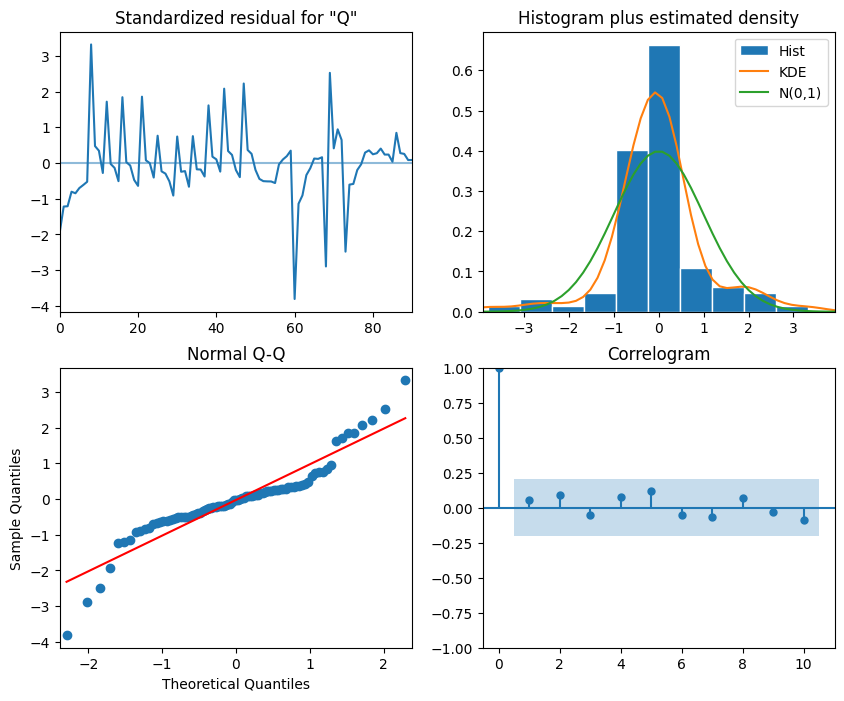

In [66]:


# Training Loop
models = []
for train in trainingsets:
    SARIMA_model = SARIMAX(train['Quantity'], order=(3,1,3), seasonal_order=(0,1,0,52), trend='ct', simple_differencing=False)
    SARIMA_model_fit = SARIMA_model.fit(disp=False)
    models.append(SARIMA_model_fit)
    
    print(SARIMA_model_fit.summary())
    SARIMA_model_fit.plot_diagnostics(figsize=(10, 8));


## Test

In [67]:


# Testing Loop
for i, SARIMA_model_fit in enumerate(models):
    #  predictions for the model
    SARIMA_pred = SARIMA_model_fit.get_prediction(start=104, end=155).predicted_mean
    # Storing predictions in the test DataFrame, ensuring no negative predictions
    test[f'SARIMA_pred_{i}'] = SARIMA_pred.apply(lambda x: max(x, 0))
    #  the error for each prediction
    test[f'Error_{i}'] = test[f'SARIMA_pred_{i}'] - test['Quantity']
    #  cumulative errors and store in a new column
    test[f'Cumulative_Error_{i}'] = test[f'Error_{i}'].cumsum()
test


,Quantity,SARIMA_pred_0,Error_0,Cumulative_Error_0,SARIMA_pred_1,Error_1,Cumulative_Error_1
144,123.0,113.952859,-9.047141,-9.047141,113.952859,-9.047141,-9.047141
145,92.0,121.698720,29.698720,20.651579,121.698720,29.698720,20.651579
146,108.0,127.934348,19.934348,40.585927,127.934348,19.934348,40.585927
147,126.0,802.021561,676.021561,716.607488,802.021561,676.021561,716.607488
148,844.0,134.015585,-709.984415,6.623073,134.015585,-709.984415,6.623073
149,148.0,137.443959,-10.556041,-3.932968,137.443959,-10.556041,-3.932968
150,99.0,141.123644,42.123644,38.190676,141.123644,42.123644,38.190676
151,101.0,144.765493,43.765493,81.956169,144.765493,43.765493,81.956169
152,999.0,844.535247,-154.464753,-72.508585,844.535247,-154.464753,-72.508585
153,115.0,152.317468,37.317468,-35.191116,152.317468,37.317468,-35.191116


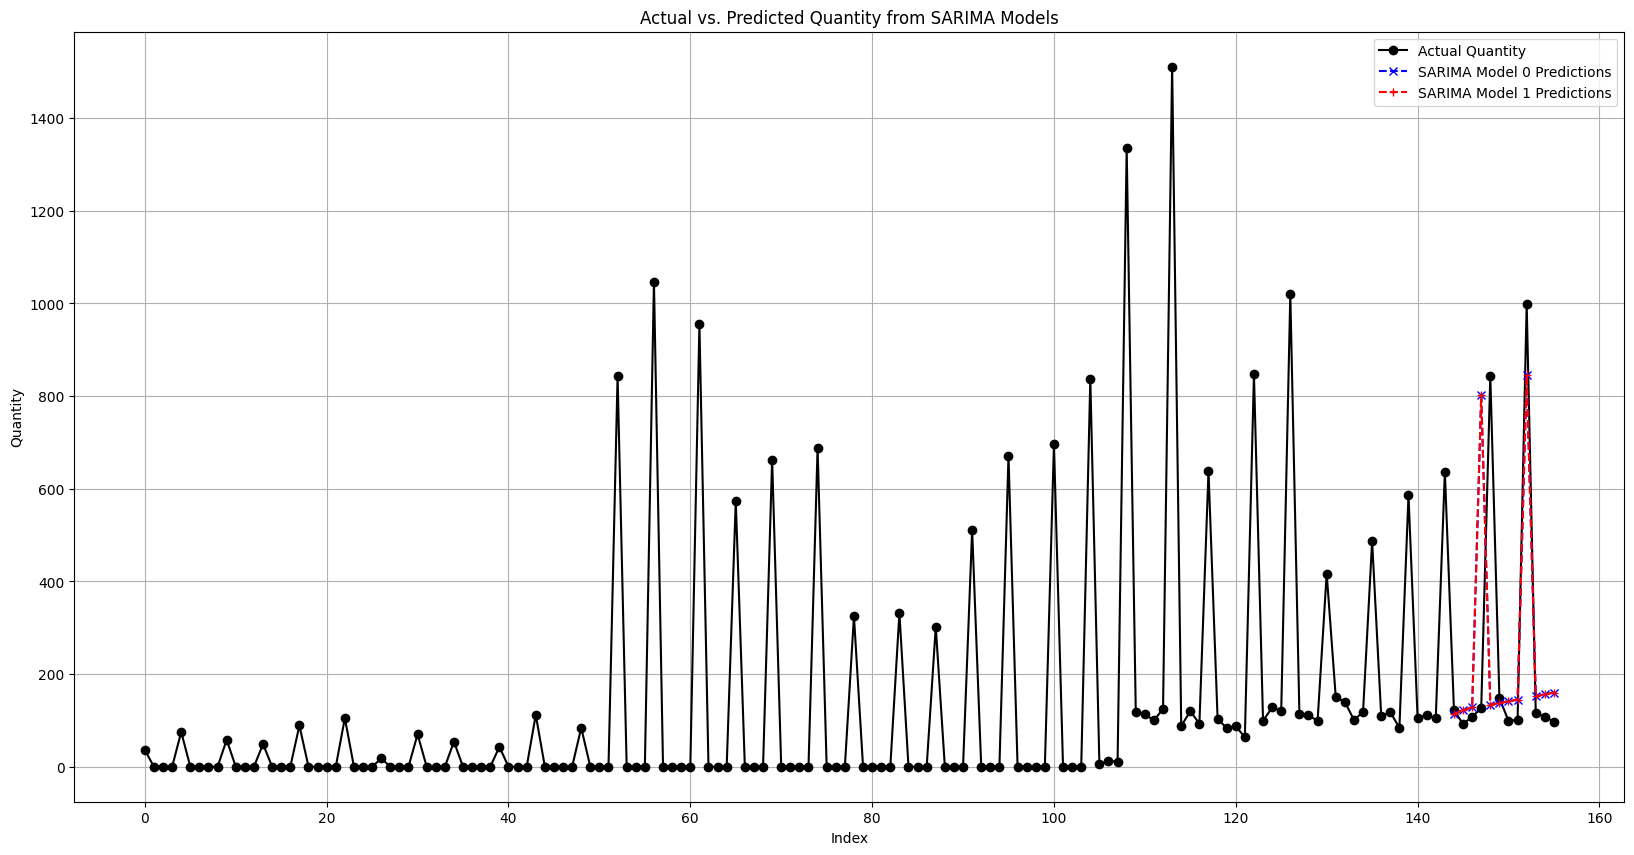

In [68]:


plt.figure(figsize=(20, 10))
plt.plot(df['Quantity'], label='Actual Quantity', color='black', marker='o', linestyle='-')  # Actual data from df
plt.plot(test['SARIMA_pred_0'], label='SARIMA Model 0 Predictions', color='blue', marker='x', linestyle='--')  # Prediction from model 0
plt.plot(test['SARIMA_pred_1'], label='SARIMA Model 1 Predictions', color='red', marker='+', linestyle='--')  # Prediction from model 1

plt.title('Actual vs. Predicted Quantity from SARIMA Models')
plt.xlabel('Index')
plt.ylabel('Quantity')
plt.legend()
plt.grid(True)
plt.show()


In [69]:
SARIMA_mae0 = mean_absolute_error(test['Quantity'], test['SARIMA_pred_0'])
SARIMA_mae1 = mean_absolute_error(test['Quantity'], test['SARIMA_pred_1'])


print(
SARIMA_mae0,
SARIMA_mae1)

153.69711211961206 153.69711211961206


In [74]:
SARIMA_mape0 = mean_absolute_percentage_error(test['Quantity'], test['SARIMA_pred_0'])
SARIMA_mape1 = mean_absolute_percentage_error(test['Quantity'], test['SARIMA_pred_1'])

print(SARIMA_mape0, SARIMA_mape1)

0.7745820625616665 0.7745820625616665


The cumulative error can show impact on inventory level over time

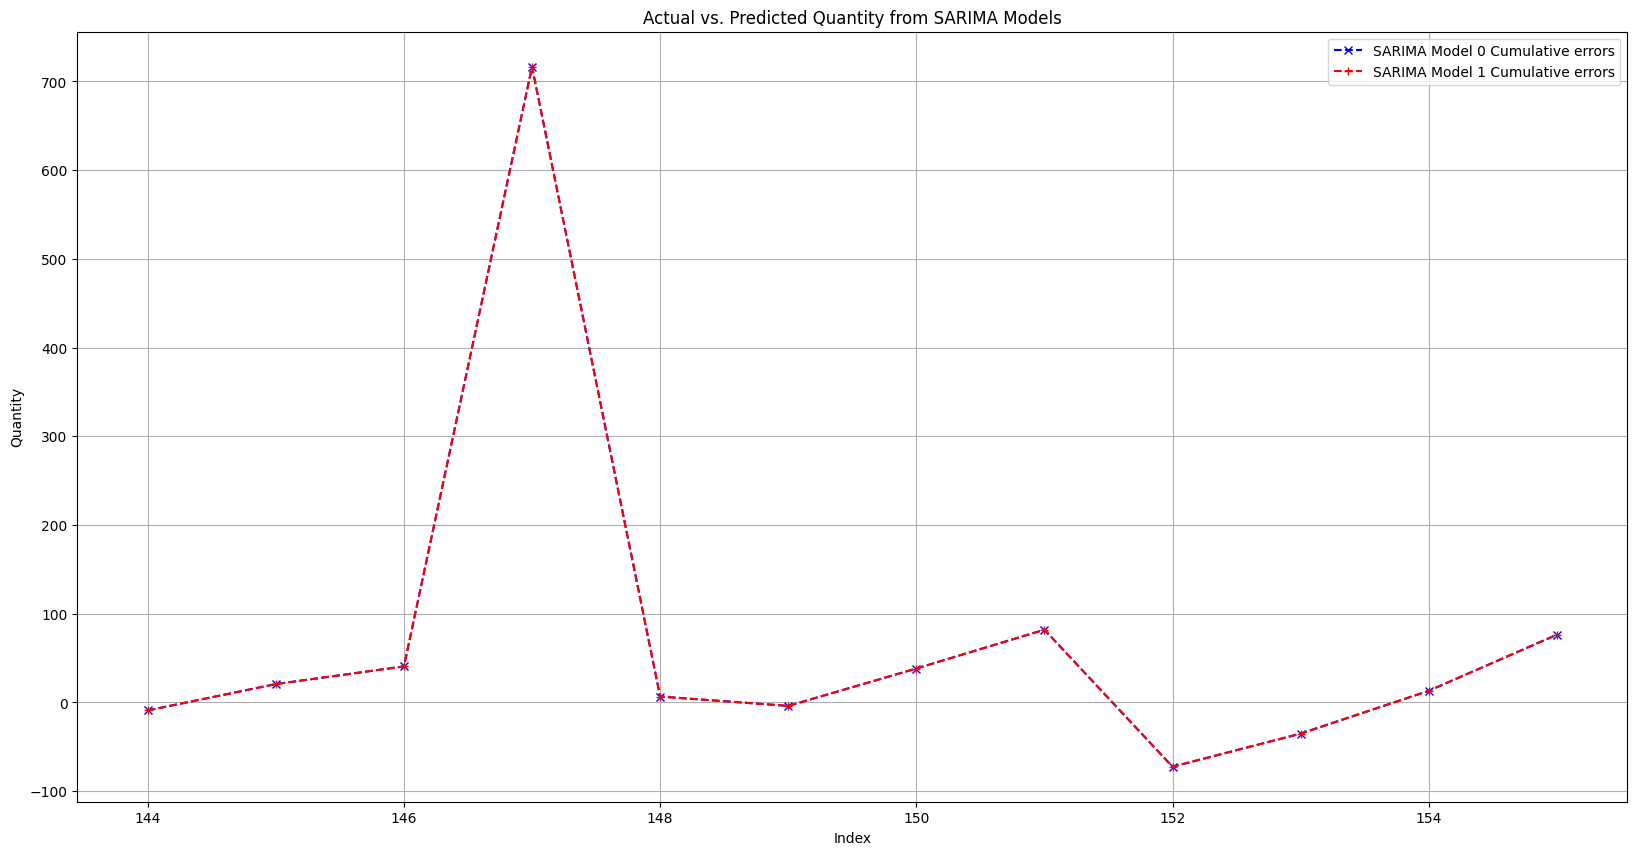

In [70]:


plt.figure(figsize=(20, 10))
plt.plot(test['Cumulative_Error_0'], label='SARIMA Model 0 Cumulative errors', color='blue', marker='x', linestyle='--')  # Prediction from model 0
plt.plot(test['Cumulative_Error_1'], label='SARIMA Model 1 Cumulative errors', color='red', marker='+', linestyle='--')  # Prediction from model 1

plt.title('Actual vs. Predicted Quantity from SARIMA Models')
plt.xlabel('Index')
plt.ylabel('Quantity')
plt.legend()
plt.grid(True)
plt.show()


 the cumulative error show that we will alway be overstocked.This model might need more improvements. Further tests might be needed. the goal is that cumulative error does not show signs of being biased